In [115]:
from utils import save_submission,load_data
import numpy as np
import copy
import matplotlib.pylab as plt
%matplotlib inline
CLASSES = 10 # note: could have inferred this automatically from the labels

In [116]:
def softmax(Z):
    """
    Convert a set of scores from a linear model into a softmax posterior
    Input:
    Z: N x C array of scores
        Z[n][:] is the set of scores for C classes for the n-th example
    Output:
    S: N x C array
        S[n][:] is the softmax distribution over C classes for the n-th example
    """
#     YOUR CODE HERE
    zexp = np.exp(Z- Z.max(1).reshape(Z.shape[0], 1))
    zexp_sum = np.sum(zexp, axis=1).reshape(Z.shape[0], 1)
    return np.divide(zexp, zexp_sum)

def predict(X, model):
    """
    Evaluate the soft predictions of the model.
    Input:
    X : N x d array (no unit terms)
    model : dictionary containing 'weight' and 'bias'
    Output:
    yhat : N x C array
        yhat[n][:] contains the softmax posterior distribution over C classes for X[n][:]
    """
    return softmax(np.dot(X, model['weight']) + model['bias'])

def test(X, Y, model):
    """
    Compute hard label assignments based on model predictions, and return the accuracy vector
    Input:
    X : N x d array of data (no constant term)
    Y : N x C array with 1-hot encoding of true labels
    model: dictionary 
    Output:
    acc : N array of errors, acc[n] is 1 if correct and 0 otherwise
    """
    return predict(X, model).argmax(-1) == Y.argmax(-1)

def error_rate(X, Y, model):
    """
    Compute error rate (between 0 and 1) for the model
    """
    return 1 - test(X, Y, model).mean()

def calc_loss(X, Y, model):
    """
    Evaluate the loss (without regularization penalty), i.e., normalized negative log likelihood
    """
    Z = predict(X, model)
    return -(Y * np.log(Z)).sum() / len(Y)

In [117]:
def calcGrad(X, Y, model):
    """
    Calculate the gradient of the loss w.r.t. model parameters
    Output:
    grad_W : same dimension as model['weight']; gradient w.r.t. the weights
    grad_b : same dimension as model['bias']; gradient w.r.t. the bias terms
    """
#     YOUR CODE HERE
    N = Y.shape[0]
    C = Y.shape[1]
    Z = copy.deepcopy(Y)
    for i in range(0, N):
        Z[i] = np.dot(model['weight'].transpose(), X[i]) + model['bias']
    prob = softmax(Z)
    grad_W = copy.deepcopy(model['weight']).transpose()
    for c in range(0, C):
        grad_W[c] = np.sum(np.dot(np.diag(prob[:, c] - Y[:, c]), X), axis = 0)
    grad_b = np.sum((prob - Y), axis = 0)
    grad_W = grad_W.transpose()
    
    return grad_W, grad_b

def modelUpdate(X, Y, model, lambda_, eta):
    """
    Update the model
    Input:
    X, Y : the inputs and 1-hot encoded labels
    model : the currrent model
    lambda : regularization coefficient for L2 penalty
    eta : learning rate
    Output:
    updated model
    """
    grad_W,grad_b = calcGrad(X,Y,model)
    
#     YOUR CODE HERE
    weight = model['weight'] - eta *grad_W - eta * lambda_ * model['weight']
    bias = model['bias'] - eta * grad_b
    nm ={'weight': weight, 'bias': bias}
    
    return nm

In [118]:
def runTrainVal(X,Y,model,Xval,Yval,trainopt):
    """
    Run the train + evaluation on a given train/val partition
    trainopt: various (hyper)parameters of the training procedure
    """
    
    eta = trainopt['eta']
    
    N = X.shape[0] # number of data points in X
    
    shuffled_idx = np.random.permutation(N)
    start_idx = 0
    for iteration in range(trainopt['maxiter']):
        if iteration % int(trainopt['eta_frac'] * trainopt['maxiter']) == 0:
            eta *= trainopt['etadrop']
        # form the next mini-batch
        stop_idx = min(start_idx + trainopt['batch_size'], N)
        batch_idx = range(N)[int(start_idx):int(stop_idx)]
        bX = X[shuffled_idx[batch_idx],:]
        bY = Y[shuffled_idx[batch_idx],:]
        if (iteration % trainopt['display_iter']) == 0:
            print('{:8} batch loss: {:.3f}'.format(iteration, calc_loss(bX, bY, model)))
        model = modelUpdate(bX, bY, model, trainopt['lambda'], eta)
        start_idx = stop_idx % N
        
    # compute train and val error; multiply by 100 for readability (make it percentage points)
    trainError = 100 * error_rate(X, Y, model)
    valError = 100 * error_rate(Xval, Yval, model)
    
    return model,valError,trainError

In [119]:
data_fn = "NOISY_MNIST_SUBSETS.h5"

print("Load small train.")
Xsmall,Ysmall = load_data(data_fn, "small_train")
print(Xsmall.shape)
print(Ysmall.shape)

print("Load large train.")
Xlarge,Ylarge = load_data(data_fn, "large_train")
print(Xlarge.shape)
print(Ylarge.shape)

print("Load val.")
Xval,Yval = load_data(data_fn, "val")
print(Xval.shape)
print(Yval.shape)

Load small train.
(400, 576)
(400, 10)
Load large train.
(8000, 576)
(8000, 10)
Load val.
(2000, 576)
(2000, 10)


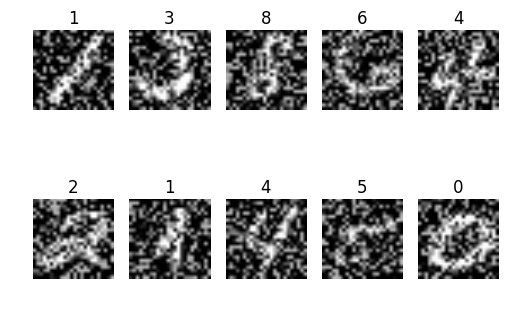

In [120]:
# -- display first ten small train examples
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(Xsmall[i,:].reshape(24,24),cmap='gray')
    plt.title(repr(Ysmall[i].argmax(-1)))
    plt.axis('off')

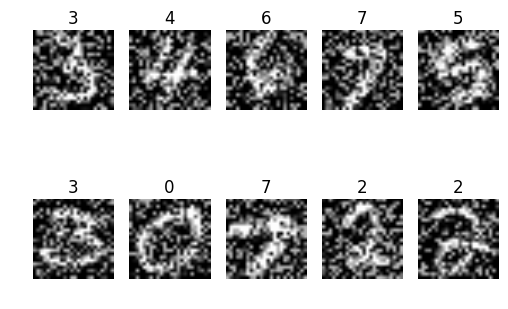

In [121]:
# -- display first ten val examples
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(Xval[i,:].reshape(24,24),cmap='gray')
    plt.title(repr(Yval[i].argmax(-1)))
    plt.axis('off')

In [122]:
# -- training options; these are suggestions, feel free to experiment
trainopt = {
    'eta': 1,   # initial learning rate
    'maxiter': 100000,   # max number of iterations (updates) of SGD
    'display_iter': 20000,  # display batch loss every display_iter updates
    'batch_size': 10,  
    'etadrop': .5, # when dropping eta, multiply it by this number (e.g., .5 means halve it)
    'eta_frac': .2  # drop eta every eta_frac fraction of the max iterations
                    # so if eta_frac is .2, and maxiter is 10000, drop eta every 2000 iterations
}

NFEATURES = Xsmall.shape[1]

seed = np.random.RandomState(2341)  # to make sure everyone starts from the same point
random_init = seed.normal(scale=0.01, size=(NFEATURES,CLASSES)) # -- with random seed fixed

model = { 'weight': random_init, 'bias': np.zeros(CLASSES) }

# set the (initial?) set of lambda values to explore
# lambdas = np.array(ENTER REASONABLE VALUES HERE, UPDATE/REFINE AS NEEDED)
lambdas = np.power(10.0, np.arange(-5, -1))

# we will maintain a record of models trained for different values of lambda
# these will be indexed directly by lambda value itself
small_trained_models = dict()
large_trained_models = dict()

# -- small train set: sweep the lambda values
for lambda_ in lambdas:
    trainopt['lambda'] = lambda_
    # -- model trained on small train set
    # note: you need deepcopy here because of the way Python handles copying of complex objects like dictionaries
    # by default, it would copy it by reference, i.e., it would make a new pointer to the same data, so later changing
    # the contents would change the "copied" version as well. deepcopy actually makes a copy.
    trained_model,valErr,trainErr = runTrainVal(Xsmall, Ysmall, copy.deepcopy(model), Xval, Yval, trainopt)
    small_trained_models[lambda_] = {'model': trained_model, "val_err": valErr, "train_err": trainErr }
    print('small train set model: -> lambda= %.4f, train error: %.2f, val error: %.2f' % (lambda_, trainErr, valErr))
    
    
for lambda_ in lambdas:
    trainopt['lambda'] = lambda_
    # -- model trained on large train set
    trained_model,valErr,trainErr = runTrainVal(Xlarge, Ylarge, copy.deepcopy(model), Xval, Yval, trainopt)
    large_trained_models[lambda_] = {'model': trained_model, "val_err": valErr, "train_err": trainErr }
    print('large train set model: -> lambda= %.4f, train error: %.2f, val error: %.2f' % (lambda_, trainErr, valErr))
    
best_small_trained_lambda = 0.
best_small_trained_model = None
best_small_trained_val_err = 100.
for lambda_,results in small_trained_models.items():
    if results['val_err'] < best_small_trained_val_err:
        best_small_trained_val_err = results['val_err']
        best_small_trained_model = results['model']
        best_small_trained_lambda = lambda_
        
best_large_trained_lambda = 0.
best_large_trained_model = None
best_large_trained_val_err = 100.
for lambda_,results in large_trained_models.items():
    if results['val_err'] < best_large_trained_val_err:
        best_large_trained_val_err = results['val_err']
        best_large_trained_model = results['model']
        best_large_trained_lambda = lambda_

print("Best small train model val err:", best_small_trained_val_err)
print("Best small train model lambda:", best_small_trained_lambda)
print("Best large train model val err:", best_large_trained_val_err)
print("Best large train model lambda:", best_large_trained_lambda)

       0 batch loss: 2.365
   20000 batch loss: -0.000
   40000 batch loss: 0.000
   60000 batch loss: 0.000
   80000 batch loss: 0.000
small train set model: -> lambda= 0.0000, train error: 0.00, val error: 32.65
       0 batch loss: 2.289
   20000 batch loss: 0.000
   40000 batch loss: 0.000
   60000 batch loss: 0.000
   80000 batch loss: 0.000
small train set model: -> lambda= 0.0001, train error: 0.00, val error: 32.10
       0 batch loss: 2.257
   20000 batch loss: 0.002
   40000 batch loss: 0.002
   60000 batch loss: 0.002
   80000 batch loss: 0.002
small train set model: -> lambda= 0.0010, train error: 0.00, val error: 31.10
       0 batch loss: 2.323
   20000 batch loss: 7.152
   40000 batch loss: 0.030
   60000 batch loss: 0.024
   80000 batch loss: 0.022
small train set model: -> lambda= 0.0100, train error: 0.00, val error: 32.30
       0 batch loss: 2.285
   20000 batch loss: 10.720
   40000 batch loss: 0.000
   60000 batch loss: 0.007
   80000 batch loss: 0.000
large train

In [123]:
#Generate a Kaggle submission file using `model`

#for model trained on small_train
kaggleX = load_data(data_fn, 'kaggle')
kaggleYhat_small = predict(kaggleX, best_small_trained_model).argmax(-1)
save_submission('submission-small.csv', kaggleYhat_small)

#for model trained on large_train
kaggleYhat_large = predict(kaggleX, best_large_trained_model).argmax(-1)
save_submission('submission-large.csv', kaggleYhat_large)


('Saved:', 'submission-small.csv')
('Saved:', 'submission-large.csv')


In [154]:
# Compute the confusion matrix
diffusion = predict(Xval, best_small_trained_model)
confusion = np.array([[0 for i in range(CLASSES)] for j in range(CLASSES)])
num_val = Yval.shape[0]
for i in range(num_val):
    ind = Yval[i,:].argmax(-1)
    ind_ = diffusion[i,:].argmax(-1)
    confusion[ind][ind_] = confusion[ind][ind_] + 1 
print confusion
ax = [i for i in range(9)]
# fig, ((ax[0], ax[1], ax[2]), (ax[3], ax[4], ax[5]), (ax[6], ax[7], ax[8])) = plt.subplots(nrows=3, ncols=3)
for i in range(CLASSES):
    plt.imsave(str(i)+'.png', best_small_trained_model['weight'][:,i].reshape(24, 24))

[[148   0   3   2   1  10  13   5   3   2]
 [  0 210   2   1   1   0   0   2   6   1]
 [  4  21 124   9   8   4   2  11  20   7]
 [  7  13  12 101   0  19   0   4  18   9]
 [  0   4   2   0 137   5   0  17   1  27]
 [  8  16   1  20  14  82   4   6   7  14]
 [  2  15  13   0  10   9 155   6   3   4]
 [  4  13   1   0   4   0   0 183   2  26]
 [  3  17   7  10   7  11   0   3 117  21]
 [  1   8   3   3  20   3   4  40   7  97]]


['model', 'val_err', 'train_err']
